# The Computation of Persistence Homology, Cohomology, Cycles and Cocycles


In this file, I go through the process of computing Persistence homology and Cohomology with a simple python implementation. It is assumed the reader has an understanding of Homology, and Cohomology.

I will go over three algorithms
- The Standard Algorithm: Computes PH directly, also computes cycle representatives
- The Dual Algorithm: Computes PH from Cohomology, also computes cocycle representatives
- The Involuted Persistence Homology Algorithm: Computes PH from Cohomology and also computes cycle and cocycle representatives

I also provide an example of each of the algorithms using the ripser and ripserer.jl libraries.

Consider the following filtered Simplicial Complex. Note that throughout this notebook the vertices will be represented as integers between 0 and 3, representing a, b, c, and d respectively.

![Filtered Simplicial Complex](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.researchgate.net%2Fprofile%2FGunnar_Carlsson3%2Fpublication%2F225181947%2Ffigure%2Ffig4%2FAS%3A668678857183248%401536436871912%2FA-filtered-complex-with-newly-added-simplices-highlighted.png&f=1&nofb=1)

Throughout this notebook, I will assume all matrices and lists are $0$-indexed unless otherwise stated


In addition to the code below we need two addition python files. fieldmath.py and matrixmath.py. These two files will help us work with matricies over a specific field of our choice.  

In [1]:
sys.path.append(r'..\..\PersistentHomology')

import matrixmath as mm
import fieldmath as fm

import numpy as np
import random
import time

To store the Filtered simplicial complex and the simplices we will use the following two classes. These classes will help us with the more tedious work involved with the algorithms, like creating our maps and keeping track of filtration values

`Simplex` stores the simplex, a tuple of vertices, and a filtration value. For example the simplex \[abc\] or \[0,1,2\] with filtration value 4 would be created with `Simplex([0, 1, 2], 4)`. the class `Simplex` has the following functions and properties
- `boundary()`: Returns a list of tuples representing the boundary simplices.
- `dimension`: Returns the dimension of the simplex. Ex: the simplex (1, 2, 3) has dimension 2
- `filtration`: Returns the filtration value of the simplex
- `simplex`: Returns the simplex as a tuple of the vertices

In [2]:
class Simplex(object):
    __data_tuple = None
    __filtration = 0

    def __init__(self, vertices, filtration=0):
        assert isinstance(vertices, list)
        vertices.sort()

        self.__data_tuple = tuple(vertices)
        self.__filtration = filtration

    def boundary(self):
        b = []
        if self.dimension < 1:
            return []
        for v in range(self.dimension + 1):
            b.append(self[:v] + self[v + 1:])
        return b

    def __getitem__(self, key):
        return self.__data_tuple[key]

    def __hash__(self):
        return hash(self.__data_tuple)

    def __eq__(self, other):
        return self[:] == other[:]

    def __str__(self):
        return str(self.simplex)

    @property
    def dimension(self):
        return len(self.__data_tuple) - 1

    @property
    def filtration(self):
        return self.__filtration

    @property
    def simplex(self):
        return self.__data_tuple


`FilteredSimplicialComplex` Stores the Filtered Simplicial Complex as a list of the simplices and a field to work over and has the following functions and properties
- `create_boundary_map()`: Creates Boundary map containing all simplices 
- `create_coboundary_map()`: Creates Coboundary matrix containing all simplices 
- `create_p_boundary_map()`: Creates Boundary matrix mapping the $p$-simplices to their corresponding $(p-1)$-simplex boundariers
- `create_p_coboundary_map()`: Creates coboundary matrix mapping $(p-1)$-simplices to their corresponding $p$-simplex. This is the anti-transpose of the boundary map
- `construct_boundary_map_from_simplices(simplices)`: Given a list of $p$-simplices, `simplices`, this creates a matrix mapping the simplices to their $(p-1)$-simplex boundariers
- `construct_coboundary_map_from_simplices(simplices, p)`: Given a list of $p-1$-simplices, `simplices`, this creates a matrix mapping the simplices to their corresponding $p$-simplices
- `get_p_simplices()`: Returns a list of $p$-simplices
- `index_to_simplex_map`: An index to simplex map representing the order used when creating the boundary map
- `simplex_to_index_map`: A simplex to index map representing the order used when creating the boundary map
- `index_to_simplex_map_inverted`: An index to simplex map representing the order used when creating the coboundary map
- `simplex_to_index_map_inverted`: A simplex to index map representing the order used when creating the coboundary map
- `num_simplices`: returns the total number of simplices in the Complex
- `get_filtration()`: returns a list of the simplices in the complex ordered by filtration value
- `field`: the field that all matricies are created over



In [3]:
class FilteredSimplicialComplex(object):
    __complex = []
    __simplex_to_index_map = None
    __index_to_simplex_map = None
    __simplex_to_index_map_inverted = None
    __index_to_simplex_map_inverted = None
    field = None

    def __init__(self, simplices, field):
        simplices.sort(key=lambda x: x.filtration)
        prev = 0
        for i in range(1, len(simplices) + 1):
            if i == len(simplices) or simplices[i][0] != simplices[i - 1][0]:
                simplices[prev: i] = sorted(simplices[prev: i], key=lambda x: x.dimension)
                prev = i
        self.__complex = simplices
        self.field = field

    def create_boundary_map(self):
        n = self.num_simplices
        b_map = mm.create_matrix(n, n, self.field, None, self.__complex, self.__complex)

        for i, s in enumerate(self):
            b_map_s = s.boundary()
            for j, b_s in enumerate(b_map_s):
                b_s_j = self.__complex.index(b_s)
                b_map[b_s_j, i] = (self.field.negate(self.field.one) if j % 2 != 0 else self.field.one)
        return b_map

    def create_coboundary_map(self):
        n = self.num_simplices
        b_map = mm.create_matrix(n, n, self.field, None, self.__complex[::-1], self.__complex[::-1])

        for i, s in enumerate(self):
            b_map_s = s.boundary()
            for j, b_s in enumerate(b_map_s):
                b_s_j = self.num_simplices - self.__complex.index(b_s) - 1
                b_map[n - i - 1, b_s_j] = (self.field.negate(self.field.one) if j % 2 != 0 else self.field.one)
        return b_map

    def create_p_boundary_map(self, p):
        p_simplices = self.get_p_simplices(p)
        return self.construct_boundary_map_from_simplices(p_simplices)

    def create_p_coboundary_map(self, p):
        pmo_simplices = self.get_p_simplices(p - 1)
        return self.construct_coboundary_map_from_simplices(pmo_simplices, p)

    def construct_boundary_map_from_simplices(self, simplices):
        # All simplices in simplices need to be the same dim
        pmo_simplices = self.get_p_simplices(simplices[0].dimension - 1) if simplices[0].dimension > 0 else [None]

        b_map = mm.create_matrix(max(1, len(pmo_simplices)), len(simplices), self.field, None, pmo_simplices, simplices)

        for i, s in enumerate(simplices):
            b_map_s = s.boundary()
            for j, b_s in enumerate(b_map_s):
                b_s_j = pmo_simplices.index(b_s)
                b_map[b_s_j, i] = (self.field.negate(self.field.one) if j % 2 != 0 else self.field.one)
        return b_map

    def construct_coboundary_map_from_simplices(self, simplices, p, revered=False):
        # All simplices in simplices need to be the same dim
        p_simplices = self.get_p_simplices(p)
        if revered:
            simplices = simplices[::-1]

        b_map = mm.create_matrix(len(p_simplices), len(simplices), self.field, None, p_simplices[::-1], simplices[::-1])

        for i, s in enumerate(p_simplices):
            b_map_s = s.boundary()
            for j, b_s in enumerate(b_map_s):
                b_s_j = len(simplices) - (simplices + [b_s]).index(b_s) - 1
                if b_s_j != -1:
                    b_map[len(p_simplices) - i - 1, b_s_j] = (self.field.negate(self.field.one) if j % 2 != 0 else self.field.one)
        return b_map

    def get_p_simplices(self, p):
        return [s for s in self if s.dimension == p]

    @property
    def simplex_to_index_map(self):
        if self.__simplex_to_index_map is None:
            self.__maps()
        return self.__simplex_to_index_map

    @property
    def index_to_simplex_map(self):
        if self.__index_to_simplex_map is None:
            self.__maps()
        return self.__index_to_simplex_map

    @property
    def simplex_to_index_map_inverted(self):
        if self.__simplex_to_index_map_inverted is None:
            self.__inverted_maps()
        return self.__simplex_to_index_map_inverted

    @property
    def index_to_simplex_map_inverted(self):
        if self.__index_to_simplex_map_inverted is None:
            self.__inverted_maps()
        return self.__index_to_simplex_map_inverted

    def __maps(self):
        self.__simplex_to_index_map = {}
        self.__index_to_simplex_map = [None]*self.num_simplices
        for i, s in enumerate(self):
            self.__simplex_to_index_map[s] = i
            self.__index_to_simplex_map[i] = s

    def __inverted_maps(self):
        self.__simplex_to_index_map_inverted = {}
        self.__index_to_simplex_map_inverted = [None]*self.num_simplices
        n = self.num_simplices - 1
        for i, s in enumerate(self):
            self.__simplex_to_index_map_inverted[s] = n-i
            self.__index_to_simplex_map_inverted[n-i] = s

    @property
    def num_simplices(self):
        return len(self.__complex)

    def get_filtration(self):
        return self.__complex

    def __getitem__(self, key):
        return self.__complex[key]


Now That we have the Filtered Simplicial Complex class created, we can create the `FilteredSimplicialComplex` object corresponding to the picture above by giving the constructor a list of the simplices along with the field to work over. For this example, we will work over the field $Z_{11}$.

In [4]:
field = fm.Zp(11)
dimension = 2  # This will be used later to tell the algorithm to only consider simplices of dimension 2 and below
filtered_simplicial_complex = FilteredSimplicialComplex(
        [Simplex([0], 0), Simplex([1], 0),
         Simplex([2], 1), Simplex([3], 1), Simplex([0, 1], 1), Simplex([1, 2], 1),
         Simplex([2, 3], 2), Simplex([0, 3], 2),
         Simplex([0, 2], 3),
         Simplex([0, 1, 2], 4),
         Simplex([0, 2, 3], 5)], field)

print(filtered_simplicial_complex)

## The Standard Algorithm
The standard algorithm works in three parts
- Create the Boundary Matrix
- Reduce the Boundary Matrix
- Compute Barcodes and cycle representatives from reduced Boundary Matrix

### Step 1: Create the Boundary Matrix

Let $\sigma=(v_0, \dots, v_{p-1})$ be a $p$-simplex with the verticies $v_0, \dots, v_{p-1}$, we will define the boundary map as the linear map that maps simplices to their boundaries, $\partial(\sigma) = \sum_{i=0}^{p-1} (-1)^i(v_0, \dots, \hat{v}_i, \dots, v_{p-1})$, where $\hat{v}_i$ represents the deletion of the vertex $v_i$. We can also proove that this is fact a valid boundary map such that $\partial\partial=0$, but i will ommit this proof. 

With the complex and field created, we need to create a boundary matrix. To do this we will create an $n\times n$ Matrix whose rows and columns correspond to simplices of the filtered cimplical complex $\sigma_0, \sigma_1, \dots, \sigma_{n-1}$ where the simplices are ordered by filtration and then by dimension. Each column $i$ is the boundary of the simplex $\sigma_i$, $\partial(\sigma_{i})$ represented as a vector.

Below is the boundary matrix of the example complex, with the bases elements corresponding to the rows and columns included.

In [5]:
boundary_map = filtered_simplicial_complex.create_boundary_map()

print(boundary_map)

              (0,)      (1,)      (2,)      (3,)      (0, 1)    (1, 2)    (2, 3)    (0, 3)    (0, 2)    (0, 1, 2) (0, 2, 3) 
    (0,):       0         0         0         0         10        0         0         10        10        0         0         
    (1,):       0         0         0         0         1         10        0         0         0         0         0         
    (2,):       0         0         0         0         0         1         10        0         1         0         0         
    (3,):       0         0         0         0         0         0         1         1         0         0         0         
    (0, 1):     0         0         0         0         0         0         0         0         0         1         0         
    (1, 2):     0         0         0         0         0         0         0         0         0         1         0         
    (2, 3):     0         0         0         0         0         0         0         0         0         0      

Once we have created our boundary map we need to reduce it into a form that allows us to obtain the relevant barcodes.

## Step 2: Reducing the Boundary Matrix 

For a boundary matrix $M$ we will define the function $low_M: \mathbb{N} \rightarrow \mathbb{N}$, where $i$ represents a column index, such that $k=low_M(i)$ is the biggest row index $k$ such that the element $M_{k,i}\neq 0$, and is undefined if no row index exists (Note, i will shorten $low_M$ to $low$ for simplicity). Additionally let $Col_M(i)$ represent the $i$th column of the matrix $M$ (i will also shorten $Col_M$ to $Col$).

Notice that because the rows are ordered by filtration $\sigma_{low(i)}$ will always represent the last added boundary simplex that makes up the boundary of the simplex $\sigma_{i}$. Notice that because this does not necessarily result in the addition of the simplex $\sigma_{i}$ we will create a hole or a feature. This feature will die when the simplex $\sigma_{i}$ is added to the filtration. Now consider two rows $i$ and $i'$ such that $i < i'$ and $low(i)=low(i')$. This means that when the simplex $\sigma_{low(i)}$ is added to the filtration we will have the boundaries for both simplices $\sigma_{i}$ and $\sigma_{i'}$ with the shared face being the simplex $\sigma_{low(i)}$. Notice that if we add these two columns together such that we cancel out the $low(i)$th row, $Col(i') = Col(i') - (M_{low(i),i}\cdot M_{low(j),j}^{-1})\cdot Col(i)$, we are left with the original $i$th row and the sum of the two rows, the $i'$th row. The $i$th row represents a feature that is born with the addition of simplex $\sigma_{low(i)}$ and dies with the addition of the simplex $\sigma_{i}$. And the new row at $i'$ that represents the boundaries from the two simplices $\sigma_{i}$ and $\sigma_j$ without their shared faces, so it is a hole or feature that is the combination of the two previous holes or features, in a sense creating a larger feature. This larger feature is born when the simplex $\sigma_{low(j)}$ is added as this is the point when the entire boundary is in the filtration and dies when $\sigma_j$ is added, as at this point the two holes in which the larger hole is made from will be filled.

In the matrix above, consider adding the last two columns together into the last column. We would be left with the column $\begin{pmatrix} 0 & 0 & 0 & 0 & 1 & 1 & 1 & 10 & 0 & 0 & 0 \end{pmatrix}^\intercal$ which is the linear combination of the simplces $(0, 1), (1, 2), (2, 3), (0, 3)$ which is the larger hole.

By repeating this process for all columns, we can reduce the matrix such that for two non-trivial columns $i$ and $j$, if $low(i)=low(j)$ then $i=j$. This implies that every non-trivial column $i$ represents the death of a unique feature, and $low(i)$ represents the birth of that feature. As we will see in the next part this allows us to find birth and the death of each feature in the complex.

I have implemented this reduction process below. Where we will iterate over all columns $i$ and add any columns with the same $low$ values. This algorithm uses the array `l_arr` to store the columns associated with low values so the algorithm does not have to search each column. This works because once a column is reduced (and we assume at each iteration $i$ all columns $j<i$ are reduced) no other reduced columns share the same low values. This means at each iteration $i$ no more than one column to the left of column $i$ will have any given low value. The array lin_com is used to determine the representatives for essential simplices which will be explained in the next part.


In [6]:
def reduce_boundary_map(b_map):
    lin_com = [[c] for c in range(b_map.columns)]
    rb_map = mm.Matrix(b_map[:, :], b_map.f, b_map.row_bases, b_map.column_bases)
    l_arr = [-1] * rb_map.rows
    for i in range(rb_map.columns):
        while rb_map.low(i) != -1 and l_arr[rb_map.low(i)] != -1:
            j = l_arr[rb_map.low(i)]
            lam = rb_map.f.multiply(rb_map[rb_map.low(i), i], rb_map.f.reciprocal(rb_map[rb_map.low(j), j]))
            rb_map.add_columns(j, i, rb_map.f.negate(lam))
            lin_com[i].append(j)
        if rb_map.low(i) != -1:
            l_arr[rb_map.low(i)] = i
    return rb_map, lin_com

In [7]:
reduced_boundary_map, _ = reduce_boundary_map(boundary_map)

print(reduced_boundary_map)

              (0,)      (1,)      (2,)      (3,)      (0, 1)    (1, 2)    (2, 3)    (0, 3)    (0, 2)    (0, 1, 2) (0, 2, 3) 
    (0,):       0         0         0         0         10        0         0         0         0         0         0         
    (1,):       0         0         0         0         1         10        0         0         0         0         0         
    (2,):       0         0         0         0         0         1         10        0         0         0         0         
    (3,):       0         0         0         0         0         0         1         0         0         0         0         
    (0, 1):     0         0         0         0         0         0         0         0         0         1         1         
    (1, 2):     0         0         0         0         0         0         0         0         0         1         1         
    (2, 3):     0         0         0         0         0         0         0         0         0         0      

### Step 3: Computing the Barcodes and Cycle representatives
Once we have our reduced matrix we can compute the barcodes and representatives
#### Barcodes
With our reduced boundary map, we know that for every non-trivial column $i$ the addition of the simplex $\sigma_low(i)$ results in the birth of a unique feature and that the addition of the simplex $\sigma_i$ results in the death that feature. This means we can extract the persistence homology simplex pairs $(\sigma_{low(i)}, \sigma_i)$ for every non-trivial column $i$ and from these pairs we can retrieve the barcodes from the filtration values of each simplex, meaning the barcodes are the pairs $(f(\sigma_{low(i)}), f(\sigma_i))$ where $f$ is a function that maps simplices to their filtration values. The dimension of the feature is the same as the dimension of $\sigma_{low(i)}$ or the simplex that creates the feature.

This strategy allows us to retrieve all persistence pairs representing features that die. However, this is not enough to retrieve the features that don't die. To find these "infinite" barcodes we need to find the simplices that create these features, called essential simplices. It turns out all simplices not paired through the process described above are essential simplices and result in the barcode $(f(\sigma_i), \infty)$, with dimension equaling the dimension of the simplex $\sigma_i$.

#### Cycle representatives 

Each barcode represents a basis element in the homology class of the complex (as homology classes are free vector spaces). And the cycle representatives are simply the combination of simplices that create the feature. Meaning the representatives are simply the columns corresponding to the death simplices.

Again this is only for the features that die. For the infinite barcodes, created from the essential simplices $\sigma_i$, we know that the $i$th column is trivial. The representative is the combination of the simplices corresponding to the columns that were used to reduce this $i$th row in addition to the simplex $\sigma_i$. For example, assume we had the same boundary matrix as above except without the last column. This means we have an essential simplex (0, 3) with the barcode $(2, \infty)$ of dimension 1. Going through the reduction process we see that the columns used to reduce the $7$th columns, the column corresponding to the simplex $(0, 3)$, are the $4$th, the $5$th and the $6$th columns meaning the representative would be $(0, 1), (1, 2), (2, 3), (0, 3)$.

The following function extracts the barcodes and the representatives from the reduced matrix as a list, where each element `[d, (i, j)]` represents a feature of dimension $d$ whose birth occurs at filtration $i$ and death at $j$. This function also works for cohomology but requires a few small changes as we will see in the next part

In [8]:
def get_bar_codes(b_map, max_dim, cohomology=False, get_representatives=True):
    """ This is only for standard and dual algorithms. And is very slow """
    # Reduce boundary/coboundary map
    reduced_b_map, lin_combs = reduce_boundary_map(b_map)
    field = reduced_b_map.f
    persistence_pairs = []
    barcodes = []
    paired = [False] * reduced_b_map.columns
    for i in range(reduced_b_map.columns):
        if reduced_b_map.low(i) != -1:
            paired[reduced_b_map.low(i)] = True
            paired[i] = True
            persistence_pairs.append([reduced_b_map.low(i), i])

    # Add essential simplices
    for i, p in enumerate(paired):
        if not p and reduced_b_map.row_bases[i].dimension < max_dim:
            persistence_pairs.append([i, None])

    # compute reps
    if get_representatives:
        representatives = []
        for pp in persistence_pairs:
            if pp[1] is not None:
                if cohomology:
                    # Cohomology persistent pairs
                    # Honesty have no clue if this is correct. Its not. or its probably not
                    representatives.append(
                        [reduced_b_map.row_bases[i].simplex for i, v in enumerate(reduced_b_map[pp[0], :])  # [pp[0], :]
                         if not field.equals(v, field.zero)])
                else:
                    # Homology persistent pairs
                    representatives.append(
                        [reduced_b_map.row_bases[i].simplex for i, v in enumerate(reduced_b_map[:, pp[1]])
                         if not field.equals(v, field.zero)])
            else:
                if cohomology:
                    representatives.append([])
                else:
                    # Rep cycles for essential Simplices
                    representatives.append([])
                    rep = lin_combs[pp[0]]
                    for i in rep:
                        if i != pp[0]:
                            for j in lin_combs[i]:
                                if i != j:
                                    rep += [j]
                        representatives[-1].append(reduced_b_map.column_bases[i].simplex)

    # Now put everything together
    for i, x in enumerate(persistence_pairs):
        bc_dim = reduced_b_map.row_bases[x[1]].dimension if cohomology and x[1] else reduced_b_map.row_bases[x[0]].dimension
        if x[1] is not None:
            if cohomology:
                bc = tuple([reduced_b_map.row_bases[x[1]].filtration, reduced_b_map.row_bases[x[0]].filtration])
            else:
                bc = tuple([reduced_b_map.row_bases[x[0]].filtration, reduced_b_map.row_bases[x[1]].filtration])
        else:
            bc = tuple([reduced_b_map.row_bases[x[0]].filtration, float("inf")])
        barcode = [bc_dim, bc]

        if get_representatives:
            barcode.append(representatives[i])
        barcodes.append(barcode)

    return sort_and_clean_barcodes(barcodes)


def sort_and_clean_barcodes(barcodes):
    barcodes = [[bc[0], tuple([bc[1][0], bc[1][1]])] + bc[2:] for bc in barcodes if bc[1][1] is None or bc[1][0] != bc[1][1]]
    barcodes.sort(key=lambda x: x[0], reverse=True)

    prev = 0
    for i in range(1, len(barcodes) + 1):
        if i == len(barcodes) or barcodes[i][0] != barcodes[i - 1][0]:
            barcodes[prev: i] = sorted(barcodes[prev: i], key=lambda x: x[1][1] - x[1][0], reverse=True)
            prev = i

    return barcodes


In [9]:
barcodes_std_alg = get_bar_codes(boundary_map, dimension, False, False)

print(barcodes_std_alg)

[[1, (2, 5)], [1, (3, 4)], [0, (0, inf)], [0, (0, 1)], [0, (1, 2)]]


As we can see from the output we obtain the barcodes exactly as we expect them to. And by setting the last parameter to True we will obtain a list of barcodes in the form `[d, (i, j), C]` Where C is a list of the faces that make up the cycle representatives for each feature

In [10]:
barcodes_std_alg_with_reps = get_bar_codes(boundary_map, dimension, False, True)

print(barcodes_std_alg_with_reps)

[[1, (2, 5), [(0, 1), (1, 2), (2, 3), (0, 3)]], [1, (3, 4), [(0, 1), (1, 2), (0, 2)]], [0, (0, inf), [(0,)]], [0, (0, 1), [(0,), (1,)]], [0, (1, 2), [(2,), (3,)]]]


As we can see from the the element \[1, \(2, 5\), \[\(0, 1\), \(1, 2\), \(2, 3\), \(0, 3\)\]\] we have a 1-dimensional hole that is born at filtration 2 and dies at filtration 5. And the representiative is the combination of the edges \(0, 1\), \(1, 2\), \(2, 3\), \(0, 3\). This output is exactly what we expected to see

## The Dual Algorithm
The dual algorithm Operates in a very similar way as the standard algorithm with a similar three steps
- Create the Coboundary Matrix
- Reduce the Coboundary Matrix
- Compute Barcodes and cocycle representatives from reduced Coboundary Matrix

The dual algorithm has the same worst-case time and space complexity as the standard algorithm, however, many more heuristics and optimizations can be used more efficiently making it faster in practice, particularly when using the Vietoris-Rips Complex.

When the cohomology classes and homology classes are Vector spaces they are isomorphic to each other, which means computing the cohomology will give us the homology and that we can easily compute the barcodes from the cohomology.

### Step 1: Create the Coboundary Matrix

Let $\partial$ be the same linear map as defined previously, which can be represented as a boundary matrix. The coboundary matrix is simply the transpose of the boundary matrix. However, in practice, it will be easier to work with the anti-transpose, which is the transpose of the boundary matrix in addition to the order of the simplices corresponding to the rows and columns being flipping.

Below is the coboundary matrix, the anti-transpose of the boundary matrix, with the basis elements for the rows and columns shown

In [11]:
coboundary_map = filtered_simplicial_complex.create_coboundary_map()

print(coboundary_map)

              (0, 2, 3) (0, 1, 2) (0, 2)    (0, 3)    (2, 3)    (1, 2)    (0, 1)    (3,)      (2,)      (1,)      (0,)      
    (0, 2, 3):  0         0         1         10        1         0         0         0         0         0         0         
    (0, 1, 2):  0         0         10        0         0         1         1         0         0         0         0         
    (0, 2):     0         0         0         0         0         0         0         0         1         0         10        
    (0, 3):     0         0         0         0         0         0         0         1         0         0         10        
    (2, 3):     0         0         0         0         0         0         0         1         10        0         0         
    (1, 2):     0         0         0         0         0         0         0         0         1         10        0         
    (0, 1):     0         0         0         0         0         0         0         0         0         1      

### Step 2: Reducing the Coboundary Matrix 

Reducing the coboundary matrix is done in the same way as the boundary matrix. Where we think of columns representing simplices that when added to the filtration result in the creations of cohomology classes, and the row $low(i)$ representing the death of that cohomology class. Because we are working with the anti-transpose and because of the nature of cohomology we can use the same reduction algorithm as before to get the reduced coboundary matrix

In [12]:
reduced_coboundary_map, _ = reduce_boundary_map(coboundary_map)

print(reduced_coboundary_map)

              (0, 2, 3) (0, 1, 2) (0, 2)    (0, 3)    (2, 3)    (1, 2)    (0, 1)    (3,)      (2,)      (1,)      (0,)      
    (0, 2, 3):  0         0         1         10        0         0         0         0         0         0         0         
    (0, 1, 2):  0         0         10        0         0         0         0         0         0         0         0         
    (0, 2):     0         0         0         0         0         0         0         0         1         0         0         
    (0, 3):     0         0         0         0         0         0         0         1         0         0         0         
    (2, 3):     0         0         0         0         0         0         0         1         10        0         0         
    (1, 2):     0         0         0         0         0         0         0         0         1         10        0         
    (0, 1):     0         0         0         0         0         0         0         0         0         1      

### Step 3: Computing the Barcodes and Cocycle representatives
#### Barcodes
With our reduced coboundary map, we once again know that for every non-trivial column $i$ the addition of the simplex $\sigma_{low(i)}$ results in the birth of a unique cohomology class and that the addition of the simplex $\sigma_i$ results in the death that cohomology class. This means we can extract the persistence cohomology pairs in the same way as before. Where the pairs are $(\sigma_{low(i)}, \sigma_i)$ for every non-trivial column $i$. However, to obtain the actual barcodes we must flip the order of the pairs as cohomology is the dual of homology and therefore cohomology death is equivalent to homology birth and vice versa. So we get our barcodes $(f(\sigma_i),f(\sigma_{low(i)}))$. The dimension of the feature, or homology class, is the same as the dimension of $\sigma_{i}$ or the simplex that results in the death of the cohomology class as this is the dimension of the simplex that would lead to the birth of the homology class or feature.

Once again this is not enough to retrieve the features that don't die. To find these infinite barcodes we need to again find the essential simplices. and It turns out all simplices not paired through the process described above are essential simplices and result in the barcodes $(f(\sigma_i), \infty)$.

#### Cocycle representatives 

We can similarly compute the cocycle representatives. However, I have been having trouble with this. So for now I will skip this part.


We retrieve the barcodes using the same function as before, but this time we will set the 4th parameter as True telling the algorithm we are using cohomology. This will then result in the algorithm returning the persistence homology barcodes.

In [13]:
barcodes_dual_alg = get_bar_codes(coboundary_map, dimension, True, False)

print(barcodes_dual_alg)

[[1, (2, 5)], [1, (3, 4)], [0, (0, inf)], [0, (1, 2)], [0, (0, 1)]]


## The Involuted Persistence Homology Algorithm
This algorithm is a modified version of the dual algorithm as described above making it more efficient and able to calculate Persistence homology cycle representatives. Before we get into the algorithm we need to define some notation. The $p$-boundary matrix, denoted $\partial_p$ is the matrix that maps all the $p$-simplices to their $(p-1)$-simplex boundaries. Similarly let the $p$-coboundary matrices denoted $d_p$ be the anti-transpose of $\partial_p$. This means we will no longer be working with square matrices or matrices whose rows and columns represent the same simplices. In this case, the basis elements, or the simplices that represent the columns and rows are stored with properties `Matrix.column_bases` and `Matrix.rows_bases`.

The $1$-boundary and $1$-coboundary matrices for the example complex are shown below along with the basis elements representing the rows and columns

In [14]:
print("1-boundary matrix")
one_boundary_matrix = filtered_simplicial_complex.create_p_boundary_map(1)
print(one_boundary_matrix)

print("1-coboundary matrix")
one_coboundary_matrix = filtered_simplicial_complex.create_p_coboundary_map(1)
print(one_coboundary_matrix)

1-boundary matrix
         (0, 1) (1, 2) (2, 3) (0, 3) (0, 2) 
    (0,):  10     0      0      10     10     
    (1,):  1      10     0      0      0      
    (2,):  0      1      10     0      1      
    (3,):  0      0      1      1      0      

1-coboundary matrix
           (3,) (2,) (1,) (0,) 
    (0, 2):  0    1    0    10   
    (0, 3):  1    0    0    10   
    (2, 3):  1    10   0    0    
    (1, 2):  0    1    10   0    
    (0, 1):  0    0    1    10   



This algorithm works in four steps
- For all $k$ (up to the desired number of homology classes to compute) compute the $k$-coboundary matrices, $d_k$
- Reduce the $k$-coboundary matrices and compute cohomology persistent pairs (and cocycles if desired)
- for all $k$ compute the matrix $D_k$ that is a minor of the boundary matrix $\partial_k$ that has only the columns corresponding to the cohomology birth simplices and essential simplices that were computed in part 1
- Reduce these matrices to compute cycle representations.

### Step 1: Create the $k$-Coboundary Matrices
To create these matrices we can use the function `create_p_coboundary_map(k)` which computes a list of the $k$-simplices and $(k-1)$-simplices and using the boundaries of the $k$-simplices creates the matrix $d_k$.

### Step 2: Reduce the $k$-Coboundary Matrices and get barcodes
Using the same reduction algorithm as before we can reduce each of these matrices and get barcodes with the same process as in the dual algorithm.

### Step 3: Create Matricies $D_k$
While computing the cohomology pairs in step 2 we keep track of the cohomology birth simplices and essential simplices. And we can create the boundary matrix with only the columns corresponding to the cohomology birth simplices and essential simplices. This can be done with the function `construct_boundary_map_from_simplices(simplices)` which will take in a list of the cohomology birth simplices and essential simplices that all have dimension $k$. 

### Step 4: Compute Cycle Representatives
Similar to the standard algorithm we will reduce the matrices $D_k$, at which point we can compute the cycle representatives in the same way as the standard algorithm. Because we created this matrix using only relevant rows the computation will be much faster than reducing the boundary matrices normally.


This entire process has been implemented in the function below.


In [15]:
def get_cohomology_pairs_from_reduced_boundary_map(reduced_b_map):
    # helper function for involuted_ph_algo
    cohomology_simplex_pairs = []
    for i in range(reduced_b_map.columns):
        if reduced_b_map.low(i) != -1:
            cohomology_simplex_pairs.append([reduced_b_map.low(i), reduced_b_map.row_bases[reduced_b_map.low(i)], i,
                                             reduced_b_map.column_bases[i]])
    return cohomology_simplex_pairs


def involuted_ph_algo(fsc, max_dim, reps=True):
    barcodes = []
    paired = [False] * fsc.num_simplices

    # we store these prev values because the essential p-simplices are computed on the p+1 iteration so we end up
    # computing $D_p$ on the p+1 iteration
    prev_cohomology_pairs = []
    prev_hom_death_simplices = []

    for p in range(max_dim + 2):
        hom_death_simplices = []
        essential_simplices = []
        if p < max_dim + 1:
            # compute reduced coboundary matrix and get cohomology pairs
            # check to see if the lin_com are the cohom cocycles??
            cb_map, _ = reduce_boundary_map(fsc.create_p_coboundary_map(p))
            cohomology_pairs = get_cohomology_pairs_from_reduced_boundary_map(cb_map)

            # compute the homology death p-simplices
            for i, birth_simplex, j, death_simplex in cohomology_pairs:
                paired[fsc.simplex_to_index_map_inverted[cb_map.row_bases[i]]] = True
                paired[fsc.simplex_to_index_map_inverted[cb_map.column_bases[j]]] = True
                hom_death_simplices.append(birth_simplex)
                # I dont compute cocycle reps. But you theoretically can here

            # Compute essential (p-1)-simplices
            for i, val in enumerate(paired):
                if not val and fsc.index_to_simplex_map_inverted[i].dimension < p:   # Big unsure if this will work
                    essential_simplices.append(fsc.index_to_simplex_map_inverted[i])
                    paired[i] = True

        # at this point we want to compute D_{p-1}
        if len(prev_hom_death_simplices) != 0 or len(essential_simplices) != 0:
            b_minor_map = fsc.construct_boundary_map_from_simplices(prev_hom_death_simplices + essential_simplices)
            reduced_minor_b_matrix, hom_lin_combs = reduce_boundary_map(b_minor_map)

            cycles = []
            ess_cycles = []
            # Compute homology rep cycles
            for col in range(reduced_minor_b_matrix.columns):
                if reduced_minor_b_matrix.low(col) != -1:
                    cycles.append([])
                    for i, v in enumerate(reduced_minor_b_matrix[:, col]):
                        if not fsc.field.equals(v, fsc.field.zero):
                            cycles[-1].append(reduced_minor_b_matrix.row_bases[i])
                else:
                    ess_cycles.append([])
                    rep = hom_lin_combs[col]
                    for i in rep:
                        if i != col:
                            for j in hom_lin_combs[i]:
                                if i != j:
                                    rep += [j]
                        ess_cycles[-1].append(reduced_minor_b_matrix.column_bases[i])

            # Put everything together
            assert len(prev_cohomology_pairs) == len(cycles), "something went wrong with cohomology pairs and cycle reps!"
            for pair, cycle in zip(prev_cohomology_pairs, cycles):
                if reps:
                    barcode = [p - 2, tuple([pair[3].filtration, pair[1].filtration]), [s.simplex for s in cycle]]
                else:
                    barcode = [p - 2, tuple([pair[3].filtration, pair[1].filtration])]
                barcodes.append(barcode)

            assert len(essential_simplices) == len(ess_cycles), "something went wrong with essential simplices and cycles!"
            for simplex, cycle in zip(essential_simplices, ess_cycles):
                if reps:
                    barcode = [p - 1, tuple([simplex.filtration, float("inf")]), [s.simplex for s in cycle]]
                else:
                    barcode = [p - 1, tuple([simplex.filtration, float("inf")])]
                barcodes.append(barcode)
        prev_cohomology_pairs = cohomology_pairs
        prev_hom_death_simplices = hom_death_simplices

    return sort_and_clean_barcodes(barcodes)

In [16]:
barcodes_inv_alg = involuted_ph_algo(filtered_simplicial_complex, dimension, False)

print(barcodes_inv_alg)

[[1, (2, 5)], [1, (3, 4)], [0, (0, inf)], [0, (1, 2)], [0, (0, 1)]]


In [17]:
barcodes_inv_alg_with_reps = involuted_ph_algo(filtered_simplicial_complex, dimension, True)

print(barcodes_inv_alg_with_reps)

[[1, (2, 5), [(0, 1), (1, 2), (2, 3), (0, 3)]], [1, (3, 4), [(0, 1), (1, 2), (0, 2)]], [0, (0, inf), [(0,)]], [0, (1, 2), [(2,), (3,)]], [0, (0, 1), [(0,), (1,)]]]


As we can see this computes the PH and representatives as expected.

## Optimizations
In this section I will talk about imporiving the above algorithms using a process known as clearing. I will also discuss a few other stratigies, however I will only provide an implementation for clearing

### Clearing
Clearing is a process that allows us to zero out rows we know will be reduced before we reduce them. if we have a persistent homology pair $(\sigma_i, \sigma_j)$ we know that $\sigma_j$ kills the feature or homology class that $\sigma_i$ creates. Clearing allows us to zero out the column at index $i$. Notice that the simplex at index $i$ is of dimension one less than that of the simplex at index $j$ this means we need to run our reduction algorithm starting at higher dimensional simplices and going towards smaller dimension ones.



In [18]:
def reduce_full_boundary_map_with_clearing(b_map, dim):
    rb_map = mm.Matrix(b_map[:, :], b_map.f, b_map.row_bases, b_map.column_bases)
    l_arr = [-1] * rb_map.rows
    for d in range(dim, -1, -1):
        for i in range(rb_map.columns):
            if rb_map.column_bases[i].dimension == d:
                while rb_map.low(i) != -1 and l_arr[rb_map.low(i)] != -1:
                    j = l_arr[rb_map.low(i)]
                    lam = rb_map.f.multiply(rb_map[rb_map.low(i), i], rb_map.f.reciprocal(rb_map[rb_map.low(j), j]))
                    rb_map.add_columns(j, i, rb_map.f.negate(lam))
                if rb_map.low(i) != -1:
                    l_arr[rb_map.low(i)] = i
                    if rb_map.low(i) != -1:
                        rb_map.clear_column(rb_map.low(i))
    return rb_map

In [19]:
boundary_map = filtered_simplicial_complex.create_boundary_map()
print(reduce_full_boundary_map_with_clearing(boundary_map, 2))

              (0,)      (1,)      (2,)      (3,)      (0, 1)    (1, 2)    (2, 3)    (0, 3)    (0, 2)    (0, 1, 2) (0, 2, 3) 
    (0,):       0         0         0         0         10        0         0         0         0         0         0         
    (1,):       0         0         0         0         1         10        0         0         0         0         0         
    (2,):       0         0         0         0         0         1         10        0         0         0         0         
    (3,):       0         0         0         0         0         0         1         0         0         0         0         
    (0, 1):     0         0         0         0         0         0         0         0         0         1         1         
    (1, 2):     0         0         0         0         0         0         0         0         0         1         1         
    (2, 3):     0         0         0         0         0         0         0         0         0         0      

Clearing becomes very advantagous along with the involuted algorithm, as we reduce the $k$-coboundary matricies. For some reason the structure of the of coboundary matricies makes the reduction of them, with clearing much faster

In [20]:
def reduce_p_boundary_and_get_clearing(b_map):
    lin_com = [[c] for c in range(b_map.columns)]
    clearing = []
    rb_map = mm.Matrix(b_map[:, :], b_map.f, b_map.row_bases, b_map.column_bases)
    l_arr = [-1] * rb_map.rows
    for i in range(rb_map.columns):
        while rb_map.low(i) != -1 and l_arr[rb_map.low(i)] != -1:
            j = l_arr[rb_map.low(i)]
            lam = rb_map.f.multiply(rb_map[rb_map.low(i), i], rb_map.f.reciprocal(rb_map[rb_map.low(j), j]))
            rb_map.add_columns(j, i, rb_map.f.negate(lam))
            lin_com[i].append(j)
        if rb_map.low(i) != -1:
            l_arr[rb_map.low(i)] = i
            clearing.append(rb_map.low(i))
    return rb_map, clearing, lin_com


def involuted_ph_algo_clearing(fsc, max_dim, reps=True):
    barcodes = []
    paired = [False] * fsc.num_simplices

    # we store these prev values because the essential p-simplices are computed on the p+1 iteration so we end up
    # computing $D_p$ on the p+1 iteration
    prev_cohomology_pairs = []
    prev_hom_death_simplices = []
    clearing = []

    for p in range(max_dim + 2):
        hom_death_simplices = []
        essential_simplices = []
        if p < max_dim + 1:
            # compute reduced coboundary matrix and get cohomology pairs
            # check to see if the lin_com are the cohom cocycles??
            cb_map = fsc.create_p_coboundary_map(p)
            for c in clearing:
                cb_map[:, c] = [cb_map.f.zero] * cb_map.rows
            cb_map, clearing, _ = reduce_p_boundary_and_get_clearing(cb_map)
            cohomology_pairs = get_cohomology_pairs_from_reduced_boundary_map(cb_map)

            # compute the homology death p-simplices
            for i, birth_simplex, j, death_simplex in cohomology_pairs:
                paired[fsc.simplex_to_index_map_inverted[cb_map.row_bases[i]]] = True
                paired[fsc.simplex_to_index_map_inverted[cb_map.column_bases[j]]] = True
                hom_death_simplices.append(birth_simplex)
                # I dont compute cocycle reps. But you theoretically can here

            # Compute essential (p-1)-simplices
            for i, val in enumerate(paired):
                if not val and fsc.index_to_simplex_map_inverted[i].dimension < p:   # Big unsure if this will work
                    essential_simplices.append(fsc.index_to_simplex_map_inverted[i])
                    paired[i] = True

        # at this point we want to compute D_{p-1}
        if len(prev_hom_death_simplices) != 0 or len(essential_simplices) != 0:
            b_minor_map = fsc.construct_boundary_map_from_simplices(prev_hom_death_simplices + essential_simplices)
            reduced_minor_b_matrix, hom_lin_combs = reduce_boundary_map(b_minor_map)

            cycles = []
            ess_cycles = []
            # Compute homology rep cycles
            for col in range(reduced_minor_b_matrix.columns):
                if reduced_minor_b_matrix.low(col) != -1:
                    cycles.append([])
                    for i, v in enumerate(reduced_minor_b_matrix[:, col]):
                        if not fsc.field.equals(v, fsc.field.zero):
                            cycles[-1].append(reduced_minor_b_matrix.row_bases[i])
                else:
                    ess_cycles.append([])
                    rep = hom_lin_combs[col]
                    for i in rep:
                        if i != col:
                            for j in hom_lin_combs[i]:
                                if i != j:
                                    rep += [j]
                        ess_cycles[-1].append(reduced_minor_b_matrix.column_bases[i])

            # Put everything together
            assert len(prev_cohomology_pairs) == len(cycles), "something went wrong with cohomology pairs and cycle reps!"
            for pair, cycle in zip(prev_cohomology_pairs, cycles):
                if reps:
                    barcode = [p - 2, tuple([pair[3].filtration, pair[1].filtration]), [s.simplex for s in cycle]]
                else:
                    barcode = [p - 2, tuple([pair[3].filtration, pair[1].filtration])]
                barcodes.append(barcode)

            assert len(essential_simplices) == len(ess_cycles), "something went wrong with essential simplices and cycles!"
            for simplex, cycle in zip(essential_simplices, ess_cycles):
                if reps:
                    barcode = [p - 1, tuple([simplex.filtration, float("inf")]), [s.simplex for s in cycle]]
                else:
                    barcode = [p - 1, tuple([simplex.filtration, float("inf")])]
                barcodes.append(barcode)
        prev_cohomology_pairs = cohomology_pairs
        prev_hom_death_simplices = hom_death_simplices

    return sort_and_clean_barcodes(barcodes)

In [21]:
barcodes_inv_alg_with_reps_clearing = involuted_ph_algo_clearing(filtered_simplicial_complex, dimension, True)

print(barcodes_inv_alg_with_reps_clearing)

[[1, (2, 5), [(0, 1), (1, 2), (2, 3), (0, 3)]], [1, (3, 4), [(0, 1), (1, 2), (0, 2)]], [0, (0, inf), [(0,)]], [0, (1, 2), [(2,), (3,)]], [0, (0, 1), [(0,), (1,)]]]


### Other Optimizations
Some other common optimization made are
- Sparse Matrix

## Point Clouds and the Rips Complex
We have seen these algorithms work for very small examples of complexes. Now we will use them with point clouds to get more interesting results

Below are two functions used to create random point clouds, and to convert point clouds to filtered simplicial complexes using Gudhi's Rips complex

In [22]:
import gudhi


def generate_point_cloud_from_sphere(num_points=100, radius=1, dim=2, error=.2):
    """
    Generates a point cloud from any dimensional sphere

    :param num_points: Number of points in generated point cloud
    :param radius: radius of sphere that points are picked from
    :param dim: dimension of the space in which the sphere will be created. dim=2 a circle, dim=3 a sphere and so on
    :param error: this specifies uncertainly in the points. With non-zero error points will be selected off of sphere with a margin of error
    :return: numpy array of the points in the point cloud
    """
    def apply_error(val):
        return val + random.uniform(-1 * error, error)
    # First generate random array of size (dim, num_points) and normalize them so they fall on unit ball
    random_points = np.random.normal(size=(dim, num_points))
    random_points /= np.linalg.norm(random_points, axis=0)

    # Return the list of random points with an error applied
    return radius * np.array([[apply_error(p) for p in row] for row in random_points]).T


def get_filtered_simplicial_complex_from_point_cloud(point_cloud, max_eps, max_dim, field):
    rips_complex = gudhi.RipsComplex(points=point_cloud, max_edge_length=2*max_eps)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dim)
    simplices = []

    for s in simplex_tree.get_filtration():
        simplices.append(Simplex(s[0], s[1]))

    return FilteredSimplicialComplex(simplices, field)

And we will also import a file `persistenceplots.py` to help plot the point cloud and cycle representatives

In [6]:
import persistenceplots

### Two dimensional Euclidean Point Clouds
To start let us create a point cloud of 25 points sampled randomly from a circle, with some small random error, in 2-dimensional euclidean space.

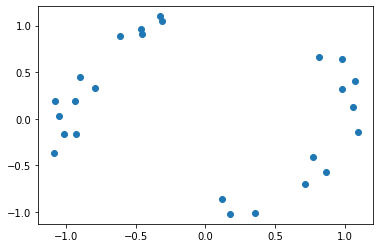

In [24]:
point_cloud_2d = generate_point_cloud_from_sphere(num_points=25, radius=1, dim=2, error=0.15)

persistenceplots.draw_point_cloud(point_cloud_2d)
persistenceplots.plt.show()

Now we can create our filtered simplicial complex. This will be done using the Gudhi library

In [25]:
fsc_2d_point_cloud = get_filtered_simplicial_complex_from_point_cloud(point_cloud=point_cloud_2d, max_eps=2, max_dim=2, field=fm.Zp(11))

Using the involuted algorithm we can compute the barcodes.

In [26]:
barcodes_2d_point_cloud = involuted_ph_algo_clearing(fsc_2d_point_cloud, dimension, True)

print(barcodes_2d_point_cloud)

[[1, (1.2601846890170272, 1.6787286092195082), [(7, 21), (11, 16), (0, 22), (0, 9), (7, 11), (2, 24), (5, 21), (2, 9), (5, 24), (16, 22)]], [0, (0.0, inf), [(0,)]], [0, (0.0, 1.1935918516082185), [(0,), (1,)]], [0, (0.0, 0.5266810092281169), [(1,), (5,)]], [0, (0.0, 0.47816437199911244), [(0,), (2,)]], [0, (0.0, 0.4186523125735452), [(2,), (9,)]], [0, (0.0, 0.27298890634139306), [(2,), (14,)]], [0, (0.0, 0.2563354897325071), [(2,), (6,)]], [0, (0.0, 0.21452605088366805), [(3,), (11,)]], [0, (0.0, 0.20880327696966652), [(2,), (12,)]], [0, (0.0, 0.20350547882997375), [(3,), (13,)]], [0, (0.0, 0.19923892888444994), [(1,), (3,)]], [0, (0.0, 0.19091847195805858), [(9,), (19,)]], [0, (0.0, 0.19066506039690265), [(9,), (23,)]], [0, (0.0, 0.17791633934364381), [(0,), (4,)]], [0, (0.0, 0.16959251835225267), [(5,), (8,)]], [0, (0.0, 0.1675254402280427), [(4,), (22,)]], [0, (0.0, 0.16375303974910235), [(6,), (24,)]], [0, (0.0, 0.1611940072976042), [(1,), (21,)]], [0, (0.0, 0.158950444488595), [(3

As we can see, the algorithm found the hole (possible more than one). Now lets see what the hole(s) looks like.

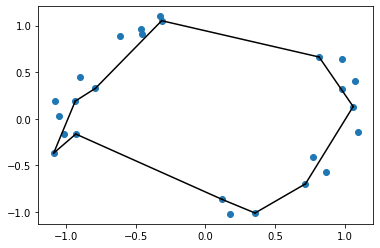

In [27]:
holes_2d_point_cloud = [[[point_cloud_2d[point] for point in face] for face in barcode[2]] for barcode in barcodes_2d_point_cloud if barcode[0] > 0]
persistenceplots.draw_point_cloud(point_cloud_2d, holes=holes_2d_point_cloud)
persistenceplots.plt.show()

Additionaly we can create barcodes and persistence diagrams to visualize the homology

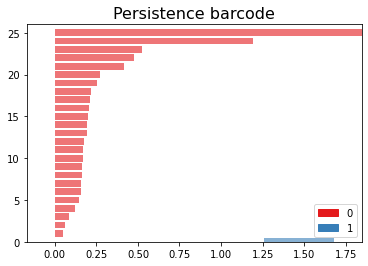

In [28]:
persistenceplots.plot_barcodes(barcodes_2d_point_cloud)
persistenceplots.plt.show()

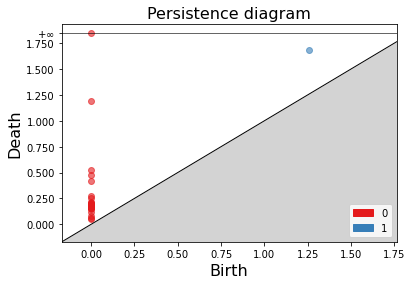

In [29]:
persistenceplots.plot_persistence_diagram(barcodes_2d_point_cloud)
persistenceplots.plt.show()

### Three Dimensional Euclidean Point Clouds
We can also do the same for 3-dimensional euclidean space. Note: with only 20 points we arent guaranteed to have nice enough data points to get a void.

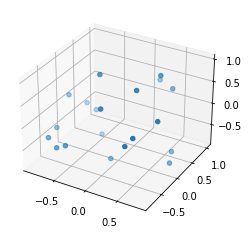

In [30]:
point_cloud_3d = generate_point_cloud_from_sphere(num_points=20, radius=1, dim=3, error=0.15)
fsc_3d_point_cloud = get_filtered_simplicial_complex_from_point_cloud(point_cloud=point_cloud_3d, max_eps=2, max_dim=3, field=fm.Zp(11))

persistenceplots.draw_point_cloud(point_cloud_3d)
persistenceplots.plt.show()

In [31]:
barcodes_3d_point_cloud = involuted_ph_algo_clearing(fsc_3d_point_cloud, 3, True)

print(barcodes_3d_point_cloud)

[[2, (1.4561468587041755, 1.6253008428286064), [(2, 8, 14), (5, 8, 14), (0, 2, 8), (0, 5, 8), (6, 9, 15), (10, 12, 15), (10, 11, 12), (11, 12, 16), (1, 11, 15), (10, 11, 15), (1, 6, 15), (0, 2, 4), (5, 12, 16), (5, 13, 16), (4, 6, 7), (4, 7, 13), (4, 6, 9), (0, 4, 5), (4, 5, 13), (9, 14, 15), (1, 6, 7), (1, 7, 11), (5, 12, 14), (12, 14, 15), (7, 11, 13), (11, 13, 16), (2, 4, 9), (2, 9, 14)]], [1, (1.150603550748419, 1.3730300236317163), [(11, 19), (11, 16), (3, 13), (3, 7), (13, 16), (7, 19)]], [1, (1.1203377109709298, 1.2819762108211743), [(12, 17), (5, 13), (12, 16), (5, 17), (13, 16)]], [1, (1.209871338641342, 1.343288969322279), [(4, 7), (1, 19), (1, 6), (7, 19), (4, 6)]], [1, (0.6758154222447651, 0.7978657020071693), [(2, 8), (0, 2), (0, 5), (5, 8)]], [1, (0.9163393757245912, 0.9443349690536573), [(17, 18), (1, 15), (10, 17), (1, 10), (15, 18)]], [0, (0.0, inf), [(0,)]], [0, (0.0, 1.0228327546281937), [(0,), (1,)]], [0, (0.0, 0.841176675409863), [(1,), (6,)]], [0, (0.0, 0.67345900

c:\users\jorqu\anaconda3\envs\scripts\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\jorqu\anaconda3\envs\scripts\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


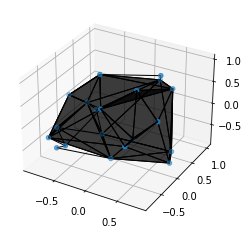

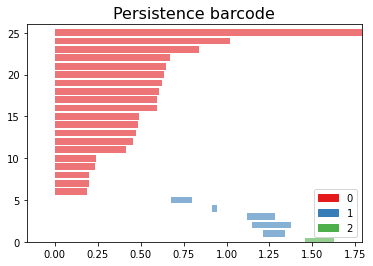

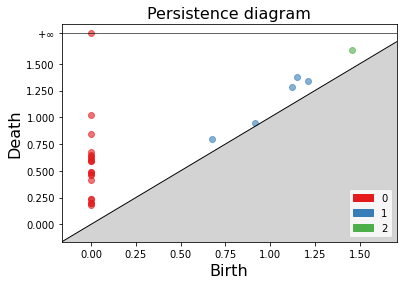

In [32]:
holes_3d_point_cloud = [[[point_cloud_3d[point] for point in face] for face in barcode[2]] for barcode in barcodes_3d_point_cloud if barcode[0] > 0]
persistenceplots.draw_point_cloud(point_cloud_3d, holes=holes_3d_point_cloud)
persistenceplots.plt.show()

persistenceplots.plot_barcodes(barcodes_3d_point_cloud)
persistenceplots.plt.show()

persistenceplots.plot_persistence_diagram(barcodes_3d_point_cloud)
persistenceplots.plt.show()

For this example we did have a void and a few holes. All of which are show in the plots above

## Benchmarking 
Now lets run a few Benchmarks on these algorithms to see which ones are the best

In [33]:
import time
dim = 3
its = 50
point_cloud = generate_point_cloud_from_sphere(num_points=12, radius=1, dim=dim, error=.2)
fsc = get_filtered_simplicial_complex_from_point_cloud(point_cloud=point_cloud, max_eps=2, max_dim=dim, field=fm.Zp(11))
print(f"Number Of Simplices: {fsc.num_simplices}")


Number Of Simplices: 793


### Standard Algorithm

In [34]:
avg_time = 0

for _ in range(its):
    start_time = time.time()
    get_bar_codes(fsc.create_boundary_map(), dim, False, True)
    end_time = time.time()
    avg_time += end_time - start_time
print(f"Average Time for standard algorithm: {avg_time / its}")

Average Time for standard algorithm: 4.260649328231811


### Dual Algorithm

In [35]:
avg_time = 0

for _ in range(its):
    start_time = time.time()
    get_bar_codes(fsc.create_coboundary_map(), dim, True, False)
    end_time = time.time()
    avg_time += end_time - start_time
print(f"Average Time for standard algorithm: {avg_time / its}")

Average Time for standard algorithm: 2.645002775192261


### Involuted Algorithm

In [36]:
avg_time = 0

for _ in range(its):
    start_time = time.time()
    involuted_ph_algo(fsc, dim, True)
    end_time = time.time()
    avg_time += end_time - start_time
print(f"Average Time for standard algorithm: {avg_time / its}")

Average Time for standard algorithm: 1.3919226789474488


### Involuted Algorithm with Clearing

In [37]:
avg_time = 0

for _ in range(its):
    start_time = time.time()
    involuted_ph_algo_clearing(fsc, dim, True)
    end_time = time.time()
    avg_time += end_time - start_time
print(f"Average Time for standard algorithm: {avg_time / its}")

Average Time for standard algorithm: 0.3251730489730835


As we can see the Involuted algorithm with clearing is about 10 times faster than the standard algorithm.

## Fast Libraries
### Ripser
Ripser is a C++ library with a python wrapper that uses the Rips complex to compute a simplicial complex from a point cloud. And can compute the barcodes as well as cocycle representatives. Unfortunately as of writing, Ripser does not have support for representative cycles. See `ripser_exampl.ipynb`
### Ripserer.jl
Ripserer.jl is a pure Julia library that uses the Rips complex to compute a simplicial complex from a point cloud. And can compute the barcodes as well as cocycle representatives and cycle representatives. See `ripserer_example.ipynb`

